Extending the concept of quadrature pairs of filters to 3D images allows you to analyze volumetric data, such as medical imaging (MRI, CT scans), scientific simulations, or any 3D datasets. In 3D, quadrature filters can help detect features like edges, surfaces, and textures by computing the local energy in the volume.

Below, I'll guide you through the following steps:

1. **Understanding Quadrature Filters in 3D**
2. **Generating 3D Gabor Filters (Even and Odd Symmetric)**
3. **Convolving the Filters with the 3D Image**
4. **Computing the Local Energy**
5. **Identifying Feature Points**
6. **Example Implementation in Python**
7. **Tips for Effective Implementation**
8. **Conclusion**

---

### **1. Understanding Quadrature Filters in 3D**

A **quadrature pair** in 3D consists of:

- **Even-Symmetric Filter (Real Part):** Sensitive to symmetric features in the volume.
- **Odd-Symmetric Filter (Imaginary Part):** Sensitive to asymmetric features.

**3D Gabor filters** are suitable for creating quadrature pairs in 3D, extending their 2D counterparts to capture volumetric features.

**Mathematical Formulation:**

The 3D Gabor filter \( G(x, y, z) \) is defined as:

$$
G(x, y, z) = \exp\left( -\frac{x'^2}{2\sigma_x^2} - \frac{y'^2}{2\sigma_y^2} - \frac{z'^2}{2\sigma_z^2} \right) \exp\left( i (2\pi f x' + \psi) \right)
$$

Where:

- $ x', y', z' $ are the rotated coordinates.
- $ \sigma_x, \sigma_y, \sigma_z $: Standard deviations of the Gaussian envelope along each axis.
- $ f $: Spatial frequency.
- $ \psi $: Phase offset (0 for even, $ \frac{\pi}{2} $ for odd).
- The rotation is defined by orientation angles (azimuth $ \theta $ and elevation $ \phi $).

### **2. Generating 3D Gabor Filters (Even and Odd Symmetric)**

#### **a. Coordinate System and Rotation**

First, define the 3D coordinate grid and apply rotation based on the desired orientation.



In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def generate_gabor_filters_3d(frequency, theta, phi, sigma_x, sigma_y, sigma_z, filter_size, offset=0):
    # Create a grid of (x, y, z) coordinates
    x_max = filter_size // 2
    y_max = filter_size // 2
    z_max = filter_size // 2
    x, y, z = np.meshgrid(
        np.arange(-x_max, x_max + 1),
        np.arange(-y_max, y_max + 1),
        np.arange(-z_max, z_max + 1),
        indexing='ij'
    )

    # Rotate the coordinates
    # Rotation matrix for azimuth (theta) and elevation (phi)
    theta = -theta  # Adjust sign for coordinate system
    phi = -phi

    # Rotation matrices
    R_theta = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

    R_phi = np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0,           1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

    R = np.dot(R_phi, R_theta)

    coords = np.stack([x, y, z], axis=-1)
    coords_rotated = np.tensordot(coords, R, axes=([3], [1]))

    x_theta = coords_rotated[..., 0]
    y_theta = coords_rotated[..., 1]
    z_theta = coords_rotated[..., 2]

    # Gaussian envelope
    gaussian_envelope = np.exp(-0.5 * (
        (x_theta**2) / sigma_x**2 +
        (y_theta**2) / sigma_y**2 +
        (z_theta**2) / sigma_z**2
    ))

    # Even-symmetric filter (real part)
    even_filter = gaussian_envelope * np.cos(2 * np.pi * frequency * x_theta + offset)

    # Odd-symmetric filter (imaginary part)
    odd_filter = gaussian_envelope * np.sin(2 * np.pi * frequency * x_theta + offset)

    return even_filter, odd_filter




**Parameters:**

- `frequency`: Spatial frequency.
- `theta`: Azimuth angle (rotation around the z-axis).
- `phi`: Elevation angle (rotation around the y-axis).
- `sigma_x`, `sigma_y`, `sigma_z`: Standard deviations of the Gaussian envelope along x, y, z axes.
- `filter_size`: Size of the filter (should be odd).
- `offset`: Phase offset (0 for even filter, \(\frac{\pi}{2}\) for odd filter).

### **3. Convolving the Filters with the 3D Image**

Convolve the 3D filters with your volumetric data.




In [3]:
from scipy.signal import fftconvolve

def apply_quadrature_filters(image, even_filter, odd_filter):
    # Convolve image with the even-symmetric filter
    response_even = fftconvolve(image, even_filter, mode='same')

    # Convolve image with the odd-symmetric filter
    response_odd = fftconvolve(image, odd_filter, mode='same')

    return response_even, response_odd



**Note:** Using `fftconvolve` from `scipy.signal` is efficient for large 3D arrays.

### **4. Computing the Local Energy**

Compute the local energy at each voxel by combining the responses.




In [4]:
def compute_local_energy(response_even, response_odd):
    # Compute the energy (magnitude)
    energy = np.sqrt(response_even**2 + response_odd**2)
    return energy




### **5. Identifying Feature Points**

Identifying local maxima in 3D requires finding voxels that are greater than their neighbors.



In [5]:
from scipy.ndimage import maximum_filter

def identify_feature_points(energy_map, size=3, threshold_rel=0.1):
    # Apply maximum filter to find local maxima
    neighborhood_size = size
    local_max = maximum_filter(energy_map, size=neighborhood_size) == energy_map

    # Apply threshold
    threshold = threshold_rel * energy_map.max()
    detected_peaks = (energy_map >= threshold) & local_max

    # Get coordinates of the peaks
    peak_coords = np.array(np.nonzero(detected_peaks)).T

    return peak_coords



**Parameters:**

- `size`: Size of the neighborhood for local maxima detection.
- `threshold_rel`: Relative threshold for energy values (0 to 1).

### **6. Example Implementation in Python**

#### **a. Load or Create a Sample 3D Image**

For demonstration, we'll create a synthetic 3D image with some features.



In [ ]:
import os

file_geo = "C:\\Users\\novalis\\OneDrive\\datasa\\geoframe\\geoframe_raw.npy"
if os.path.exists(file_geo):
	geo = np.load(file_geo)
else:
	print(f"File not found: {file_geo}")

file_geo_detect="C:\\Users\\novalis\\OneDrive\\datasa\\geoframe\\geoframe_demo_detectII.dat"
if os.path.exists(file_geo_detect):
    geo_detect = np.fromfile(file_geo_detect, dtype=np.float32)
    geo_detect = geo_detect.reshape(geo.shape[0], geo.shape[1], geo.shape[2])



In [7]:
np.save("geoframe_raw.npy", geo)
np.save("geoframe_demo_detectII.npy", geo_detect)



#### **b. Set Parameters and Generate Filters**




In [47]:
# Parameters for the Gabor filters
frequency = 0.1/1         # Spatial frequency
theta = np.pi / 2.1       # Azimuth angle (45 degrees)
phi = np.pi / 3        # Elevation angle (30 degrees)
sigma_x = sigma_y =2
sigma_z = 2  # Standard deviations
filter_size = 15        # Should be odd

# Generate the quadrature filters
even_filter, odd_filter = generate_gabor_filters_3d(
    frequency, theta, phi, sigma_x, sigma_y, sigma_z, filter_size
)
print(f"even_filter.shape={even_filter.shape}, odd_filter.shape={odd_filter.shape}")    

even_filter.shape=(15, 15, 15), odd_filter.shape=(15, 15, 15)


In [48]:
#smooth the image using gaussina filter 
from scipy.ndimage import gaussian_filter
geo_smooth = gaussian_filter(geo, sigma=1)


#### **c. Apply Filters and Compute Local Energy**




In [53]:
# Apply the filters to the image
response_even, response_odd = apply_quadrature_filters(geo_smooth, even_filter, odd_filter)

# Compute the local energy
energy = compute_local_energy(response_even, response_odd)



#### **d. Identify Feature Points**




In [54]:
# Identify feature points in the energy map
peak_coords = identify_feature_points(energy, size=5, threshold_rel=0.5)

print(f"Number of feature points detected: {len(peak_coords)}")


Number of feature points detected: 9602



#### **e. Visualization**

Visualizing 3D data is more complex. We'll plot slices and overlay detected points.

```python


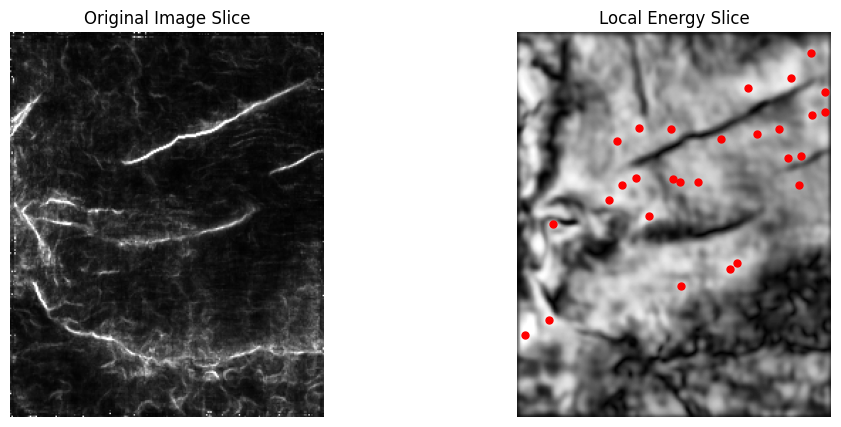

In [58]:
# Select a slice to visualize
slice_index = 260  # Middle slice

plt.figure(figsize=(12, 5))

# Original Image Slice
plt.subplot(1, 2, 1)
plt.imshow(geo_detect[:, :, slice_index], cmap='gray')
plt.title('Original Image Slice')
plt.axis('off')

# Energy Map Slice
plt.subplot(1, 2, 2)
plt.imshow(energy[:, :, slice_index], cmap='gray')
plt.title('Local Energy Slice')
plt.axis('off')

# Overlay detected peaks on the energy map
slice_peaks = peak_coords[peak_coords[:, 2] == slice_index]
plt.plot(slice_peaks[:, 1], slice_peaks[:, 0], 'ro', markersize=5)

plt.show()


In [ ]:
def min_max_normalization(image):
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image
def z_score_normalization(image):
    mean = image.mean()
    std = image.std()
    normalized_image = (image - mean) / std
    return normalized_image

from skimage import exposure

def clahe_3d(image, clip_limit=0.01, nbins=256):
    # Apply CLAHE slice by slice along the z-axis
    equalized_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        equalized_image[:, :, i] = exposure.equalize_adapthist(
            image[:, :, i],
            clip_limit=clip_limit,
            nbins=nbins
        )
    return equalized_image


energy = min_max_normalization(energy)
# energy = z_score_normalization(energy)
energy = clahe_3d(energy, clip_limit=0.01, nbins=256)


In [59]:

#to visualize in 3d
np.save('geo_energy.npy', energy)
#export matlab format
energy.tofile('geo_energy.dat')
#export matlab format *.mat 
import scipy.io
scipy.io.savemat('geo_energy.mat', {'energy': energy})





**Note:** For a complete visualization, consider using volumetric rendering or interactive visualization libraries like `Mayavi` or `Plotly`.

### **7. Tips for Effective Implementation**

#### **a. Multiple Orientations and Frequencies**

To capture features at different orientations and scales, create a filter bank:

```python


In [61]:
def generate_gabor_filter_bank(frequencies, thetas, phis, sigma_x, sigma_y, sigma_z, filter_size):
    filters = []
    for frequency in frequencies:
        for theta in thetas:
            for phi in phis:
                even_filter, odd_filter = generate_gabor_filters_3d(
                    frequency, theta, phi, sigma_x, sigma_y, sigma_z, filter_size
                )
                filters.append((even_filter, odd_filter))
    return filters



**Example Usage:**




In [62]:
frequencies = [0.05, 0.1, 0.15]
thetas = [0, np.pi/4, np.pi/2]
phis = [0, np.pi/6, np.pi/3]
filter_bank = generate_gabor_filter_bank(
    frequencies, thetas, phis, sigma_x, sigma_y, sigma_z, filter_size
)




#### **b. Applying the Filter Bank**

In [63]:
def apply_filter_bank(image, filter_bank):
    energy_maps = []
    for even_filter, odd_filter in filter_bank:
        response_even, response_odd = apply_quadrature_filters(image, even_filter, odd_filter)
        energy = compute_local_energy(response_even, response_odd)
        energy_maps.append(energy)
    return energy_maps


```

#### **c. Combining Energy Maps**

Combine energy maps to enhance feature detection.

```python


In [64]:
energy_maps = apply_filter_bank(image, filter_bank)
combined_energy = np.max(energy_maps, axis=0)



#### **d. Computational Considerations**

- **Memory Usage:** 3D arrays can be large. Ensure you have sufficient memory.
- **Performance:** Convolution in 3D is computationally intensive. Use FFT-based convolution and consider parallel processing.
- **GPU Acceleration:** Libraries like CuPy or PyTorch can leverage GPU acceleration.

#### **e. Parameter Tuning**

- **Sigma Values:** Control the spatial extent of the filter. Larger values detect broader features.
- **Frequency:** Higher frequencies detect finer details.
- **Orientation Angles:** Multiple orientations help detect features in different directions.

#### **f. Noise Consideration**

- **Smoothing:** Consider smoothing the image before processing.
- **Threshold Adjustment:** Adjust `threshold_rel` based on the noise level.

### **8. Conclusion**

By extending quadrature pairs of filters to 3D images, you can effectively detect and analyze volumetric features by computing the local energy and identifying its local maxima. 3D Gabor filters serve as excellent candidates for such filters due to their localization properties in both spatial and frequency domains.

---

**Feel free to ask if you need further clarification or assistance with adapting this approach to your specific application!**

---

**Additional Resources:**

- **Visualization Libraries:**
  - **Mayavi:** For 3D visualization in Python.
  - **Plotly:** Interactive 3D plots in the browser.
- **GPU Acceleration Libraries:**
  - **CuPy:** NumPy-like API accelerated with NVIDIA CUDA.
  - **PyTorch:** Deep learning framework with support for GPU computations.
- **Optimized Convolution:**
  - Use libraries like `scipy.signal.fftconvolve` or `scipy.ndimage` for efficient convolution.

**Note:** When working with large volumetric data and filter banks, be mindful of computational efficiency and memory usage. Optimize your code and consider using more efficient libraries if necessary.

In [66]:
frequencies = [0.05, 0.1, 0.15]
thetas = [0, np.pi/4, np.pi/2]
phis = [0, np.pi/6, np.pi/3]
filter_bank = generate_gabor_filter_bank(
    frequencies, thetas, phis, sigma_x, sigma_y, sigma_z, filter_size
)